In [2]:
import pandas as pd
import numpy as np
import random 
import os
import json

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 50)


from functions import evaluate_clustering_stability, run_clustering_model

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
df_all_stocks = pd.read_csv('stocks_data_FINAL.csv', index_col='Date')
df_all_stocks.index = pd.to_datetime(df_all_stocks.index)

stocks_df_weekly = df_all_stocks.resample('W').last() #aggregating on a weekly level
stocks_df_3days = df_all_stocks.resample('3D').last()# aggregating on a twice per week basis to arrive at the sweet spot of that 250 (1 year) timeseries length

In [6]:
from functions import test_clustering_metrics
random.seed(42)


n_clusters_list = [2,3,4,5,6,7,8,9,10]
df_with_label_balance = pd.DataFrame()
linkage_list = ['average', 'complete', 'single']
method = 'kshape'
for window in [1,7,10,14,30,60]:
    for df_dict in [{'weekly': stocks_df_weekly}, {'3day': stocks_df_3days}, {'full': df_all_stocks}]:
        if method != 'ahc':
            linkage_list = None
        print(f'Doing window size {window} with {list(df_dict.keys())[0]} aggregation')
        output = test_clustering_metrics(df_dict, n_clusters_list, method=method, linkage_list=linkage_list, 
                               return_mode='geometric', window=window, n_init=3)
        df_with_label_balance = pd.concat([df_with_label_balance, output])

df_with_label_balance.to_csv(f'NEW_CLUSTERING_TUNING_FINAL/stocks_only/{method}.csv', index=False)

Doing window size 1 with weekly aggregation
Doing window size 1 with 3day aggregation
Doing window size 1 with full aggregation
Doing window size 7 with weekly aggregation
Doing window size 7 with 3day aggregation
Doing window size 7 with full aggregation
Doing window size 10 with weekly aggregation
Doing window size 10 with 3day aggregation
Doing window size 10 with full aggregation
Doing window size 14 with weekly aggregation
Doing window size 14 with 3day aggregation
Doing window size 14 with full aggregation
Doing window size 30 with weekly aggregation
Doing window size 30 with 3day aggregation
Doing window size 30 with full aggregation
Doing window size 60 with weekly aggregation
Doing window size 60 with 3day aggregation
Doing window size 60 with full aggregation


In [7]:
#kmeans_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/cryptos_only/kmeans.csv')
kshape_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/stocks_only/kshape.csv')
#ahc_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/cryptos_only/ahc.csv')

results = pd.concat([kshape_results])

In [8]:
results[['silhouette_norm']] = MinMaxScaler().fit_transform(results[['silhouette_score']])
results['entropy_norm_clusters'] = results['entropy'] / np.log2(results['clusters']) #normalize relative to the K clusters


# Filter on only strong silhouette values and reasonable entropy
results_filtered = results[results['silhouette_norm'] > 0.5]
results_filtered = results_filtered[results_filtered['entropy_norm_clusters'] > 0.6]

# Compute total score: average of silhouette and normalized entropy
#results_filtered['total_score'] = (results_filtered['silhouette_norm'] + results_filtered['entropy_norm_clusters']) / 2

In [9]:
results_filtered

,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,silhouette_norm,entropy_norm_clusters
0,2,0.083431,kshape,not_applicable,geometric,1,weekly,0.291861,0.9144,0.818618,0.914400
1,3,0.092279,kshape,not_applicable,geometric,1,weekly,0.248725,1.5558,0.839949,0.981601
2,4,0.105827,kshape,not_applicable,geometric,1,weekly,0.219113,1.9711,0.872611,0.985550
3,5,0.113882,kshape,not_applicable,geometric,1,weekly,0.199832,2.2170,0.892030,0.954810
4,6,0.119967,kshape,not_applicable,geometric,1,weekly,0.188565,2.4359,0.906697,0.942335
...,...,...,...,...,...,...,...,...,...,...,...
157,6,0.068109,kshape,not_applicable,geometric,60,full,0.088784,2.5639,0.781682,0.991852
158,7,0.049975,kshape,not_applicable,geometric,60,full,0.082665,2.7856,0.737964,0.992251
159,8,0.059222,kshape,not_applicable,geometric,60,full,0.076792,2.9380,0.760258,0.979333
160,9,0.070962,kshape,not_applicable,geometric,60,full,0.071252,3.1245,0.788559,0.985670


In [10]:
#CLUSTERING STABILITY
from functions import evaluate_clustering_stability
filtered_results_with_stability = results_filtered.copy()
for row in filtered_results_with_stability.iterrows():

    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        agg_level = 3
    elif row[1]['df_mode'] == 'weekly':
        agg_level = 5
    else:
        agg_level = 1

    results = evaluate_clustering_stability(df_all_stocks, n_clusters=n_clusters, window_size=252, step_size=30, agg_level=agg_level, smoothing_window=window_size, method=method, linkage=linkage, crypto_only=True)
    if len(results) > 20:
        break
    ari_mean = results['ari'].mean()
    nmi_mean = results['nmi'].mean()

    filtered_results_with_stability.loc[row[0], 'ari_mean'] = ari_mean
    filtered_results_with_stability.loc[row[0], 'nmi_mean'] = nmi_mean

filtered_results_with_stability.to_csv('filtered_results_with_stability_STOCKS_ONLY.csv')

In [11]:
filtered_results_with_stability = pd.read_csv('filtered_results_with_stability_STOCKS_ONLY.csv')
filtered_results_with_stability['ari_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['ari_mean']])
filtered_results_with_stability['nmi_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['nmi_mean']])
filtered_results_with_stability['stability_score'] = (filtered_results_with_stability['nmi_norm'] + filtered_results_with_stability['ari_norm']) / 2

#filtered_results_with_stability = filtered_results_with_stability[filtered_results_with_stability['stability_score'] > 0.5]#.sort_values('entropy_norm_clusters', ascending=False)

filtered_results_with_stability['renormalized_silhouette'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['silhouette_score']])
filtered_results_with_stability['renormalized_inertia'] = 1 - MinMaxScaler().fit_transform(filtered_results_with_stability[['inertia']])
filtered_results_with_stability['renormalized_stability'] = 1 - MinMaxScaler().fit_transform(filtered_results_with_stability[['stability_score']])

filtered_results_with_stability['final_score'] = filtered_results_with_stability[['renormalized_silhouette', 'renormalized_inertia', 'renormalized_stability']].mean(axis=1)

In [12]:
filtered_results_with_stability.sort_values('final_score', ascending=False)

,Unnamed: 0,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,...,entropy_norm_clusters,ari_mean,nmi_mean,ari_norm,nmi_norm,stability_score,renormalized_silhouette,renormalized_inertia,renormalized_stability,final_score
108,108,2,0.126497,kshape,not_applicable,geometric,30,weekly,0.072500,0.8598,...,0.859800,0.053683,0.046760,0.026851,0.024023,0.025437,0.836122,0.864421,0.974563,0.891702
138,144,2,0.139142,kshape,not_applicable,geometric,60,3day,0.075595,0.9021,...,0.902100,0.100774,0.093478,0.084710,0.081289,0.083000,0.900533,0.853101,0.917000,0.890211
139,145,3,0.079674,kshape,not_applicable,geometric,60,3day,0.065055,1.5411,...,0.972326,0.107941,0.125294,0.093516,0.120288,0.106902,0.597616,0.891645,0.893098,0.794120
81,81,2,0.086901,kshape,not_applicable,geometric,14,weekly,0.126392,0.9988,...,0.998800,0.058136,0.040826,0.032322,0.016748,0.024535,0.634428,0.667342,0.975465,0.759078
123,124,9,0.080898,kshape,not_applicable,geometric,30,3day,0.065641,3.1453,...,0.992232,0.126820,0.287838,0.116712,0.319531,0.218122,0.603850,0.889505,0.781878,0.758411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,3,0.100537,kshape,not_applicable,geometric,1,3day,0.265990,1.5335,...,0.967531,0.447761,0.414648,0.511040,0.474974,0.493007,0.703885,0.156838,0.506993,0.455906
12,12,5,0.135219,kshape,not_applicable,geometric,1,3day,0.210059,2.0387,...,0.878020,0.765229,0.739519,0.901100,0.873194,0.887147,0.880552,0.361376,0.112853,0.451593
9,9,2,0.096418,kshape,not_applicable,geometric,1,3day,0.300115,0.9872,...,0.987200,0.401257,0.330094,0.453902,0.371329,0.412616,0.682908,0.032045,0.587384,0.434112
19,19,3,0.133221,kshape,not_applicable,geometric,1,full,0.257679,1.5071,...,0.950874,0.783082,0.728950,0.923036,0.860239,0.891637,0.870373,0.187232,0.108363,0.388656


In [13]:
from sklearn.metrics import v_measure_score

def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    try:
        methods_clusters = cluster_dict[method]
    except:
        methods_clusters = cluster_dict.copy()

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure

with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

with open('tickers_with_region.json') as f:
    region_dict = json.load(f)

with open('tickers_with_market.json') as f:
    market_dict = json.load(f)


classes_levels = {'exchange': exchanges_dict, 
'sector': sector_dict,
'market': market_dict,
'region': region_dict}


random.seed(42)

df_with_all_results_filtered = filtered_results_with_stability.copy()
for i, row in enumerate(df_with_all_results_filtered.iterrows()):
    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        df = stocks_df_3days
    elif row[1]['df_mode'] == 'weekly':
        df = stocks_df_weekly
    else:
        df = df_all_stocks
    
    df = df.rolling(window=window_size, center=False).mean().dropna()

    random.seed(42)
    results, tickers_with_labels, _, _ = run_clustering_model(df, n_clus=n_clusters, model_name=method, linkage=linkage, return_mode='geometric', n_init=3)
    for class_name, class_dict in classes_levels.items():
        v_measure = clustering_v_measure(tickers_with_labels, class_dict, method=method)

        col_name = f'{class_name}_v_measure'
        if col_name not in df_with_all_results_filtered.columns:
            df_with_all_results_filtered[col_name] = np.nan
        df_with_all_results_filtered.at[i, col_name] = v_measure



df_with_all_results_filtered.sort_values('market_v_measure', ascending=False).to_csv('RESULTS_WITH_V_MEASURE_STOCKS.csv', index=False)


In [14]:
#FINAL SELECTION
df_with_all_results_filtered = pd.read_csv('RESULTS_WITH_V_MEASURE_STOCKS.csv')
v_measure_cols = [col for col in df_with_all_results_filtered.columns if 'v_measure' in col]
v_measure_cols.remove('exchange_v_measure')
df_with_all_results_filtered = df_with_all_results_filtered.drop(columns=['exchange_v_measure'])


df_with_all_results_filtered['mean_v_measure'] = df_with_all_results_filtered[v_measure_cols].mean(axis=1)
df_with_all_results_filtered['normalized_mean_v_measure'] = MinMaxScaler().fit_transform(df_with_all_results_filtered[['mean_v_measure']])

final_selection_clustering = df_with_all_results_filtered.copy()
# final_selection_clustering = df_with_all_results_filtered[df_with_all_results_filtered['normalized_mean_v_measure'] > 0.5]
# final_selection_clustering = final_selection_clustering[final_selection_clustering['stability_score'] > 0.5]


final_selection_clustering['renormalized_silhouette'] = MinMaxScaler().fit_transform(final_selection_clustering[['silhouette_score']])
final_selection_clustering['renormalized_stability'] = MinMaxScaler().fit_transform(final_selection_clustering[['stability_score']])
final_selection_clustering['renormalized_v_measure'] = MinMaxScaler().fit_transform(final_selection_clustering[['mean_v_measure']])

#final_selection_clustering['renormalized_inertia'] = MinMaxScaler().fit_transform(1 - final_selection_clustering[['inertia']]) #ALSO INVERT INERTIA SCORE TO BE HIGHER = BETTER

final_selection_clustering['final_score'] = final_selection_clustering[['renormalized_silhouette', 'renormalized_stability', 'renormalized_v_measure']].mean(axis=1)

final_selection_clustering.loc[final_selection_clustering['final_score'].idxmax()]

Unnamed: 0                               25
clusters                                  9
silhouette_score                   0.156985
method                               kshape
linkage                      not_applicable
return_mode                       geometric
window_size                               1
df_mode                                full
inertia                            0.172015
entropy                              2.8237
silhouette_norm                     0.99594
entropy_norm_clusters              0.890778
ari_mean                           0.845723
nmi_mean                           0.842968
ari_norm                                1.0
nmi_norm                                1.0
stability_score                         1.0
renormalized_silhouette             0.99142
renormalized_inertia               0.500498
renormalized_stability                  1.0
final_score                         0.99714
sector_v_measure                   0.307721
market_v_measure                

In [ ]:
#3 clus, 3day 30days
#BEST - 2clus weekly 10 days

In [22]:
df = df_all_stocks.rolling(window=1, center=False).mean()
labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=9, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)

In [23]:
with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

with open('tickers_with_region.json') as f:
    region_dict = json.load(f)

with open('tickers_with_market.json') as f:
    market_dict = json.load(f)

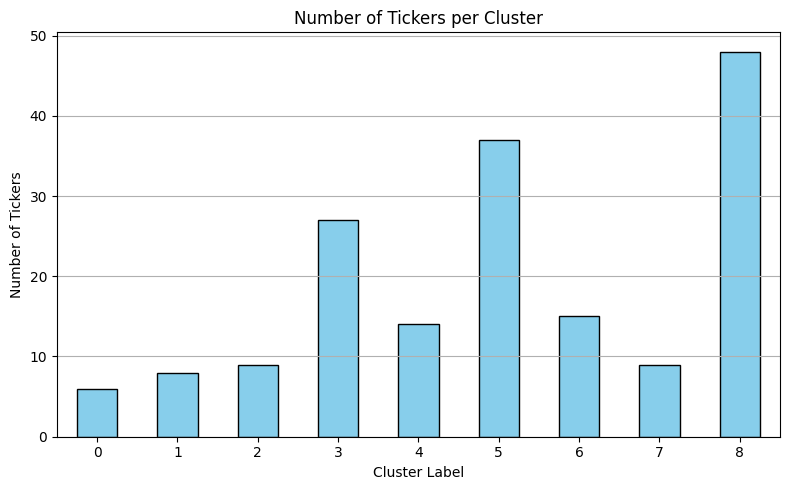

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample dictionary
ticker_cluster_dict = tickers_with_labels_kshape
# Convert to DataFrame
df_clusters = pd.DataFrame(list(ticker_cluster_dict.items()), columns=['ticker', 'cluster'])

# Count number of tickers per cluster
cluster_counts = df_clusters['cluster'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Tickers per Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


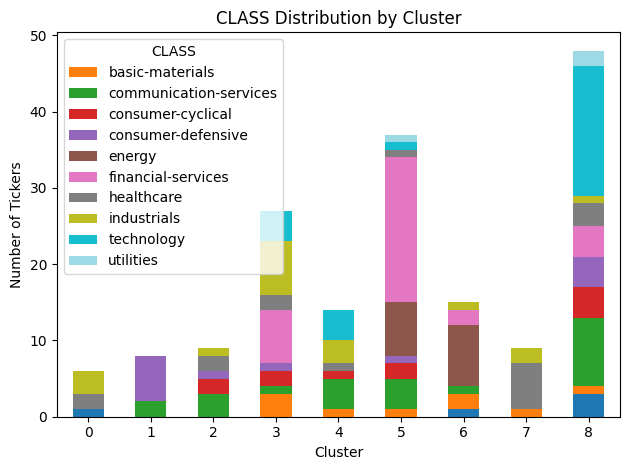

In [34]:
def visualise_cryptos_in_clusters(ticker_to_class:dict, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False):
    # final_tickers = list(ticker_to_class.keys())
    # for x in [for t in final_tickers if 'USDT' in t]:
    #     final_tickers.remove(x)
    df = pd.DataFrame({
    'Ticker': [t for t in ticker_to_class.keys() if 'USDT' not in t],
    'CLASS': [ticker_to_class[t] for t in ticker_to_class if 'USDT' not in t],
    'Cluster': [ticker_to_cluster_all[t] for t in ticker_to_class if 'USDT' not in t]
    })

    if just_cryptos:
        df = df[df['CLASS'] == 'crypto']

    pivot = df.groupby(['Cluster', 'CLASS']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of CLASSES per Cluster')
        plt.xlabel('CLASS')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('CLASS Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='CLASS')
        plt.tight_layout()

        
    plt.show()


visualise_cryptos_in_clusters(sector_dict, tickers_with_labels_kshape, 'kshape', just_cryptos=False, heatmap=False)